## Sandbox for getting article pair similarity after filtering by named entities 

In [362]:
import pandas as pd
import numpy as np
from ast import literal_eval
import re
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import distance 
import seaborn as sns

In [226]:
#get data with content, embeddings, and named entities 
df = pd.read_csv("/shared/3/projects/benlitterer/localNews/NetworkMVP/dataWithEmbeddings.tsv", sep="\t", converters={"embedding":lambda x: np.array(x.strip("[]").split(), dtype=float)})

/opt/anaconda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (2,3,7,10,11,12,13,14,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,39,40,41,42) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [291]:
print(max(pd.to_datetime(df["date"])))
print(min(pd.to_datetime(df["date"])))
print(df.shape)

2021-09-01 00:00:00
2021-05-01 00:00:00
(308837, 48)


In [319]:
testDf = df[["key", "topics", "embedding"]]

print("parsing")

def cleanList(inList): 
    return [str(re.sub("[^a-zA-Z0-9 ]", "", item).lower()) for item in inList]

def parseList(inStr): 
    split = inStr.split("\'), (\'")
    return [cleanList(item.split("', '")) for item in split]

#parse topics from string to actual list of tuples 
testDf["topics"] = testDf["topics"].apply(parseList)

print("parsed")

#test out idea for creating reverse mapping 
testDf = testDf.dropna(subset=["topics"])

#bring each tuple into its own row 
testDf = testDf.explode("topics")

#bring each tuple entry into its own column 
#split ent_type, entity pairs to columns 
testDf[["ent_type","entity"]] = pd.DataFrame(testDf["topics"].tolist(), index=testDf.index)

print("formatted") 

#keep only the entity types that may be interesting 
toKeep = ["org","event", "person", "work_of_art", "product"]
testDf = testDf[testDf["ent_type"].isin(toKeep)]

grouped = testDf[["embedding", "ent_type", "entity", "key"]].groupby(by=["ent_type", "entity"]).agg(list)

parsing


<ipython-input-319-80b088d75f01>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testDf["topics"] = testDf["topics"].apply(parseList)


parsed
formatted


In [326]:
grouped["articleNum"] = grouped["key"].apply(len)
grouped.head()

embedding  \
ent_type entity                                                                 
event     fields2value1970  [[-0.00773029588, -0.00490123546, 0.0179314595...   
          game 2            [[-0.0185301453, 0.0250518899, 0.0244161058, -...   
          game of thrones   [[-0.0230182633, 0.0624324679, 0.00821057428, ...   
          hall of fame      [[-0.0627424344, 0.0551135093, 0.00766856782, ...   
          mars 2020         [[-0.0456677824, -0.00853861216, 0.0276035238,...   

                                                                          key  \
ent_type entity                                                                 
event     fields2value1970  [hillsborofreepress_Infinity_Fitness_has_offic...   
          game 2            [theseattletimes_76ers’_Rivers_seeks_fill-in_f...   
          game of thrones   [thenewyorktimes_Seth_Meyers_Explains_How_‘For...   
          hall of fame      [dailydemocrat_49ers’_Hall_of_Fame:_John_Taylo...   
          mars 2020                   [cbsnews_How_NASA_flew_a_drone_on_Mars]   

                            articleNum  
ent_type entity                         
event     fields2value1970           6  
          game 2                     1  
          game of thrones            1  
          hall of fame               3  
          mars 2020                  1

In [329]:
grouped.shape

(1011755, 3)

In [335]:
groupedLean = grouped[(grouped["articleNum"] > 5) & (grouped["articleNum"] < 500)]
groupedLean.shape

(112774, 3)

Text(0.5, 0.98, 'Named Entity Cluster Size Distribution')

<Figure size 3600x2400 with 0 Axes>

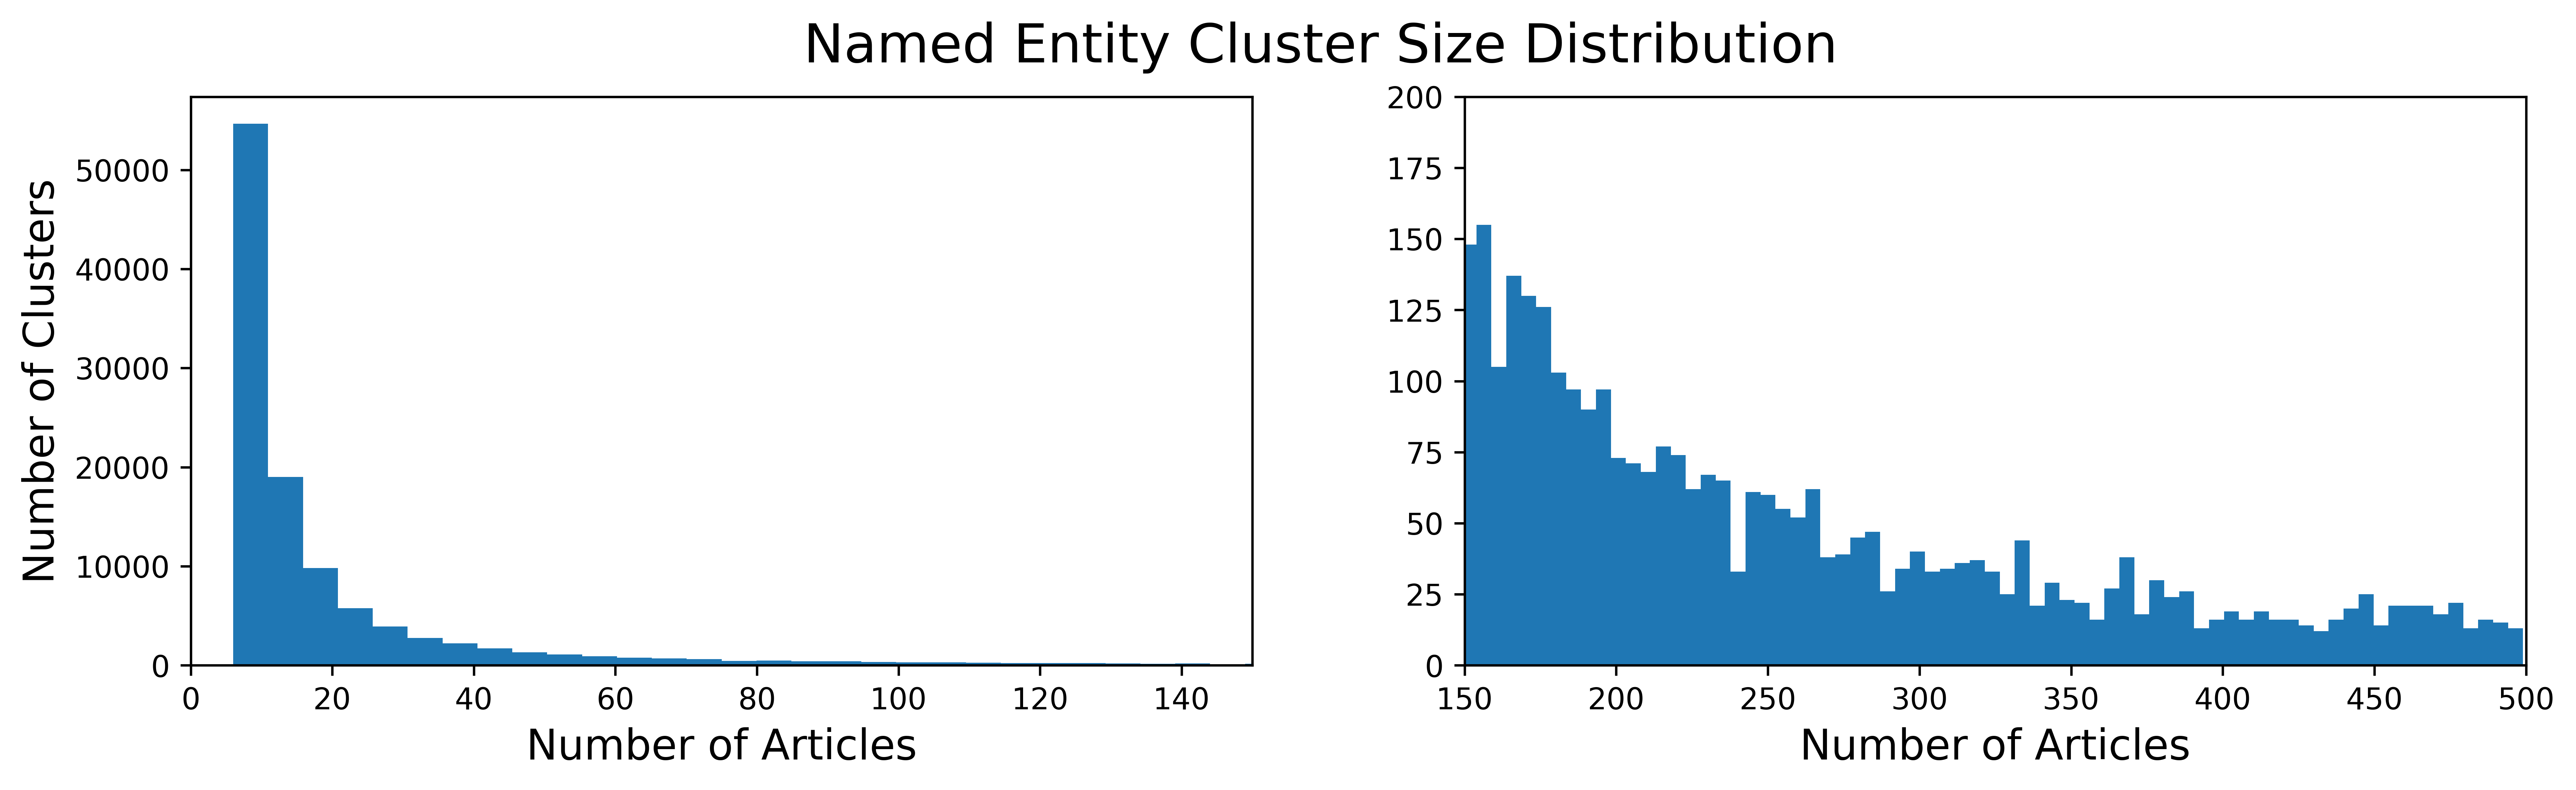

In [336]:
plt.clf()
plt.rcParams['figure.dpi'] = 600
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[14, 3.5])

axs[0].hist(groupedLean["articleNum"], bins=100)
axs[0].set_xlim([0, 150])
axs[0].set_xlabel("Number of Articles", size=14)
axs[0].set_ylabel("Number of Clusters", size=14)

axs[1].hist(groupedLean["articleNum"], bins=100)
axs[1].set_xlim([150, 500])
axs[1].set_ylim([0, 200])
axs[1].set_xlabel("Number of Articles", size=14)
fig.suptitle("Named Entity Cluster Size Distribution", size=18)


Text(0.5, 1, 'Entity Cluster: 911')

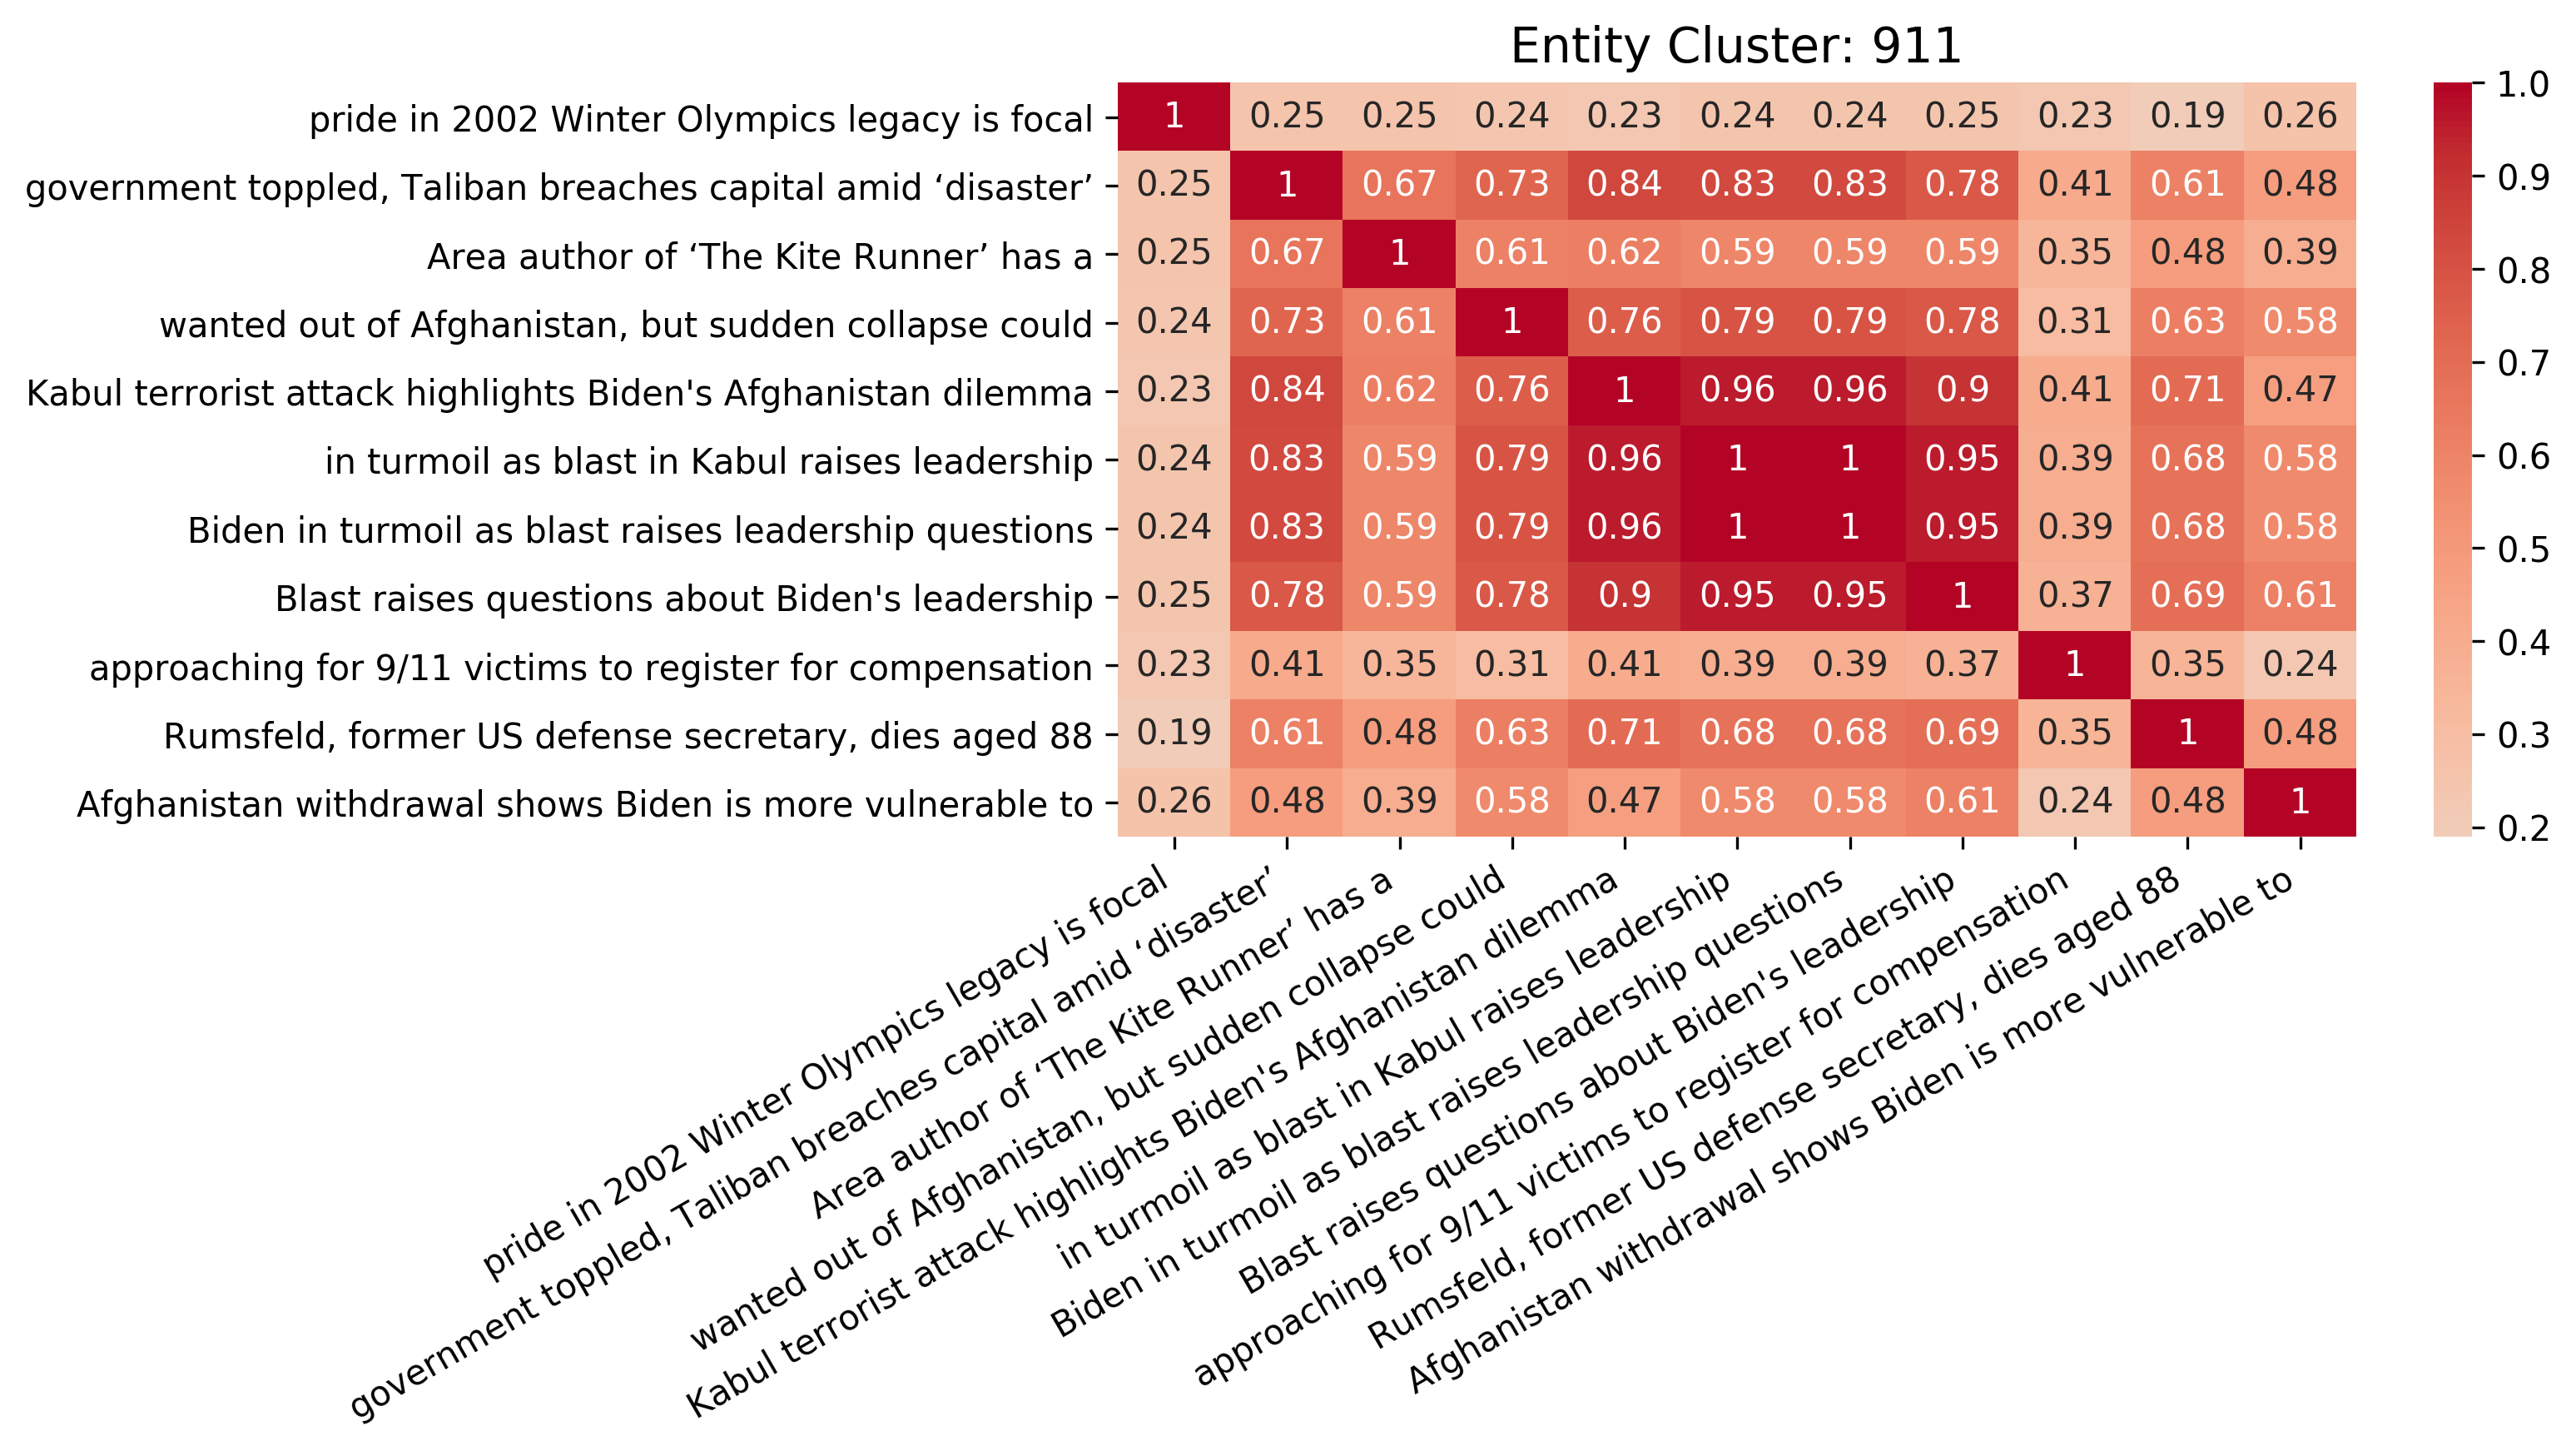

In [394]:
plt.rcParams['figure.dpi'] = 300
fig, axs = plt.subplots(figsize=[8,4])
#start working with clustering code 
example = groupedLean["embedding"][3]

outList = np.empty(shape=(len(example), len(example)))
for i, outer in enumerate(example): 
    innerList = []
    for j, inner in enumerate(example): 
        outList[i][j] = 1 - distance.cosine(outer, inner)


groupedLean["key"][0]
labels = [" ".join(lab.split("_")[2:10]) for lab in groupedLean["key"][3]]
sns.heatmap(outList, cmap="coolwarm", center=0, annot=True, xticklabels=labels, yticklabels=labels)
axs.set_xticklabels(labels, rotation=30, ha="right")
plt.title("Entity Cluster: 911", size=14)
#create a heatmap for sanity checking. Maybe need to filter out content using key from dataframe? 

In [211]:

#Alternate attempt to create reverse mapping 
#testDf= df[["key", "topics"]].dropna(subset=["key", "topics"]).head(1000)
#outDict = {val:[] for key, val in testDict.items()}

print("dict made")

outDict = {}
count = 0
for outlet, entList in testDict.items(): 
    for subList in entList:
        
        #there must be some sort of parsing error and on occasion we don't have the right number of entities 
        if len(subList) == 2: 
            entType, ent = subList
            if entType in toKeep:
                
                
                key = str(entType) + "_" + str(ent)

                #add a bunch of things for entity types etc... 
                #can we make the pairwise comparison dictionary at the same time? 
                if key not in outDict: 
                    outDict[key] = [outlet]
                else: 
                    outDict[key].append(outlet)
                
        else: 
            #print(subList)
            pass
        
#looks great!
print(list(outDict.items())[:3])

dict made
[('person_kay ivey', ['andalusiastarnews_Ivey_announces_end_of_participation_in_all_Federal_Pandemic_Unemployment_Compensation_Programs:_Covington_County_sees_decrease_in_unemployment_in_March', 'atmoreadvance_Unemployment_benefits_set_to_change_for_Alabama_residents', 'thebrewtonstandard_Unemployment_benefits_set_to_change_for_Alabama_residents', 'thebrewtonstandard_State_could_lose_vaccine_doses_to_other_states', 'troymessenger_Only_one,_final_legislative_day_remains_in_the_2020_session', 'thevalleytimesnews_Ivey_awards_grants_for_broadband_services', 'valleytimesnews_Ivey_awards_grants_for_broadband_services', 'clantonadvertiser_Clanton_approves_reserve_officer_updates', 'atmoreadvance_Fully_vaccinated?_Resume_activities', 'atmoreadvance_Vaccine_eligibility_expanded_to_those_12_and_older']), ('org_peuc', ['andalusiastarnews_Ivey_announces_end_of_participation_in_all_Federal_Pandemic_Unemployment_Compensation_Programs:_Covington_County_sees_decrease_in_unemployment_in_March

In [210]:
entList

[['date', 'this week'],
 ['org', 'us army corps of engineers lock'],
 ['cardinal', '7'],
 ['gpe', 'east franklin township']]

In [195]:
list(outDict.items())[:3]

[('person',
  ['andalusiastarnews_Ivey_announces_end_of_participation_in_all_Federal_Pandemic_Unemployment_Compensation_Programs:_Covington_County_sees_decrease_in_unemployment_in_March',
   'andalusiastarnews_Ivey_announces_end_of_participation_in_all_Federal_Pandemic_Unemployment_Compensation_Programs:_Covington_County_sees_decrease_in_unemployment_in_March',
   'andalusiastarnews_Ivey_announces_end_of_participation_in_all_Federal_Pandemic_Unemployment_Compensation_Programs:_Covington_County_sees_decrease_in_unemployment_in_March',
   'andalusiastarnews_Ivey_announces_end_of_participation_in_all_Federal_Pandemic_Unemployment_Compensation_Programs:_Covington_County_sees_decrease_in_unemployment_in_March',
   'andalusiastarnews_Ivey_announces_end_of_participation_in_all_Federal_Pandemic_Unemployment_Compensation_Programs:_Covington_County_sees_decrease_in_unemployment_in_March',
   'andalusiastarnews_Ivey_announces_end_of_participation_in_all_Federal_Pandemic_Unemployment_Compensation_

In [135]:
def parse(s):
    tuples = s.strip("[]").split('), ')
    out = []
    print(tuples)
    for x in tuples:
        a,b = x.strip('()').split(', ')
        out.append((a,b))
    return out

#df["topics"].dropna().head(20000).apply(parseNERs)
df["topics"].head(1000).apply(literal_eval)

0      [(PERSON, Kay Ivey), (DATE, today), (GPE, Alab...
1      [(DATE, 34), (PERSON, Melinda Manuel), (DATE, ...
2      [(PERSON, Cathy Reeves Edmondson), (DATE, age ...
3      [(PERSON, Alice Yelverton DeForest), (DATE, 86...
4      [(ORG, Judson College), (ORDINAL, fifth), (GPE...
                             ...                        
995    [(DATE, Thursday), (ORG, Class B State Track a...
996    [(ORG, Notre Dame’s), (ORG, Parker McNees), (O...
997    [(PERSON, Jagger Thibodeaux), (NORP, Northside...
998    [(PERSON, ABBY), (CARDINAL, two), (DATE, as a ...
999    [(GPE, United States), (NORP, Americans), (CAR...
Name: topics, Length: 1000, dtype: object

In [136]:
entList = ["ORG","EVENT", "PERSON", "WORK_OF_ART", "PRODUCT"]

#test out idea for creating reverse mapping 
testDf = df[["key", "topics"]].head(1000).dropna(subset=["topics"])
testDf["topics"] = testDf["topics"].apply(list)

#time consuming part is these three print statements 
print("list applied")
#split lists of tuples into seperate rows (i.e. long format )
testDf = testDf.explode(["topics"])


list applied


ValueError: column must be a scalar

In [34]:
embDict = testDf[["key", "embedding", "topics"]].set_index("key").to_dict("index")
count = 1
for k, v in embDict.items(): 
    if count < 3: 
        print(k)
        print(np.array(v["embedding"].astype(list)))
        print(v["topics"])
    count += 1

andalusiastarnews_Ivey_announces_end_of_participation_in_all_Federal_Pandemic_Unemployment_Compensation_Programs:_Covington_County_sees_decrease_in_unemployment_in_March


AttributeError: 'str' object has no attribute 'astype'